This notebook contains the second part of the implementation of the Euler-Bernoulli Beam using L1 error. In this notebook the Lambda values for the different error terms are optimized with optuna. The hyperparameters that were optimized in the first notebook are already implemented. In the end a final model is trained and used to predict displacement, velocity, acceleration and bending moment.

In [1]:
!pip install optuna
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 13.9 MB/s eta 0:00:00


In [2]:
def f_exact(x, t):
    return (1 - 16  * np.pi**2) * torch.sin(x) * torch.cos(4 * np.pi * t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

/tmp/ipython-input-54349312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
/tmp/ipython-input-54349312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)


In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([f_gen, u_gen], dim=1).to(device)
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1).to(device)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1).to(device)  # Shape: [N_val, 2]

batch_size = 300
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [8]:
# save the normalizers to use in result file
torch.save({
    "x_mean": x_normalizer.normmean,
    "x_std": x_normalizer.normstd,
    "t_mean": t_normalizer.normmean,
    "t_std": t_normalizer.normstd,
    "u_mean": u_normalizer.normmean,
    "u_std": u_normalizer.normstd,
}, "normalizers_Euler_L1.pt")

# Model Definition

In [9]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = F.tanh(layer(x))    # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [10]:
# Define parameters
L = np.pi
T_end = 1

# Set sample sizes
N_f = 10000 # collocation points in interior
N_ic = 2000 # initial condition samples at t=0
N_bc = 2000 # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 150

# echo on screen
echo_every = 30

In [11]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            # Extract only the u component from the target (second column) and unsqueeze to match pred shape
            target_u = target[:, 1].unsqueeze(1)
            loss = loss_function(pred, target_u)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [12]:
def objective(trial):

    hidden_size = 400
    optimiser = torch.optim.AdamW
    learning_rate = 0.0011559206131664627
    num_layers = 1
    lambda_data = trial.suggest_float('lambda_data', 0.05, 1)
    lambda_ic = trial.suggest_float('lambda_ic', 0.05, 1)
    lambda_bc = trial.suggest_float('lambda_bc', 1, 10, log=True)
    lambda_physics = trial.suggest_float('lambda_physics', 0.05, 1)

    pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()


    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        # Use the pre-stacked inputs_train for pinn input
        u_pred_data = pinn(inputs_train)
        # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
        target_u_norm = outputs_train[:, 1].unsqueeze(1)
        loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

        # initial condition
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_ic_2 = torch.mean(torch.abs(dudt - 0))

        # boundary condition left
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_left_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
        loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))


        # boundary condition right
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_right_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
        loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

        # compute physics loss
        EI = 1
        rhoA = 1
        u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
        u_f_denorm = u_normalizer.denormalize(u_f)
        u_f = u_f_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
        d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
        loss_physics = torch.mean(torch.abs(physics_residual))

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()

        # Check if the trial has exceeded the maximum allowed time
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()


    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-29 14:49:58,087] A new study created in memory with name: no-name-a62e5b69-bddd-403f-ad6e-9fbd31b1b610


Epoch 0: total loss = 36.118340, validation_loss = 1.219866, loss_data = 0.839665, loss_ic_1 = 0.457920, loss_ic_2 = 0.202240, loss_bc_left_1 = 0.123346, loss_bc_left_2 = 0.029573, loss_bc_right_1 = 0.075482, loss_bc_right_2 = 0.035681, loss_physics = 63.586025
Validation loss at epoch 0: 1.219866
Epoch 30: total loss = 34.770237, validation_loss = 0.823823, loss_data = 0.797110, loss_ic_1 = 0.627958, loss_ic_2 = 0.039538, loss_bc_left_1 = 0.037458, loss_bc_left_2 = 0.014926, loss_bc_right_1 = 0.087246, loss_bc_right_2 = 0.011018, loss_physics = 61.504498
Validation loss at epoch 30: 0.823823
Epoch 60: total loss = 24.871973, validation_loss = 0.855285, loss_data = 0.839932, loss_ic_1 = 0.676234, loss_ic_2 = 0.039975, loss_bc_left_1 = 0.226639, loss_bc_left_2 = 0.029114, loss_bc_right_1 = 0.218698, loss_bc_right_2 = 0.027575, loss_physics = 42.343372
Validation loss at epoch 60: 0.855285
Epoch 90: total loss = 14.496412, validation_loss = 0.570714, loss_data = 0.577225, loss_ic_1 = 0.5

[I 2026-01-29 14:50:33,175] Trial 0 finished with value: 0.11622306890785694 and parameters: {'lambda_data': 0.6691566361244184, 'lambda_ic': 0.4023572415358659, 'lambda_bc': 1.5966557750210886, 'lambda_physics': 0.5483784911360935}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 2.737639, validation_loss = 0.116223, loss_data = 0.121300, loss_ic_1 = 0.075467, loss_ic_2 = 0.127492, loss_bc_left_1 = 0.117936, loss_bc_left_2 = 0.079438, loss_bc_right_1 = 0.115137, loss_bc_right_2 = 0.058984, loss_physics = 3.613668
Validation loss at epoch 150: 0.116223
  Params: 
    lambda_data: 0.6691566361244184
    lambda_ic: 0.4023572415358659
    lambda_bc: 1.5966557750210886
    lambda_physics: 0.5483784911360935
Epoch 0: total loss = 35.161949, validation_loss = 1.284376, loss_data = 0.815020, loss_ic_1 = 0.701848, loss_ic_2 = 0.051058, loss_bc_left_1 = 0.037890, loss_bc_left_2 = 0.016087, loss_bc_right_1 = 0.063306, loss_bc_right_2 = 0.009652, loss_physics = 63.194672
Validation loss at epoch 0: 1.284376
Epoch 30: total loss = 33.365547, validation_loss = 0.786572, loss_data = 0.771968, loss_ic_1 = 0.607260, loss_ic_2 = 0.205167, loss_bc_left_1 = 0.055674, loss_bc_left_2 = 0.009055, loss_bc_right_1 = 0.054651, loss_bc_right_2 = 0.005856, loss_phy

[I 2026-01-29 14:50:57,278] Trial 1 finished with value: 0.12125779315829277 and parameters: {'lambda_data': 0.6722447598026516, 'lambda_ic': 0.09298646230889218, 'lambda_bc': 1.0676564360489091, 'lambda_physics': 0.5444845670403815}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 2.574535, validation_loss = 0.121258, loss_data = 0.113978, loss_ic_1 = 0.093362, loss_ic_2 = 0.312178, loss_bc_left_1 = 0.137855, loss_bc_left_2 = 0.107082, loss_bc_right_1 = 0.144820, loss_bc_right_2 = 0.153253, loss_physics = 3.453645
Validation loss at epoch 150: 0.121258
  Params: 
    lambda_data: 0.6722447598026516
    lambda_ic: 0.09298646230889218
    lambda_bc: 1.0676564360489091
    lambda_physics: 0.5444845670403815
Epoch 0: total loss = 5.132517, validation_loss = 1.180604, loss_data = 0.821704, loss_ic_1 = 0.608672, loss_ic_2 = 0.049360, loss_bc_left_1 = 0.068852, loss_bc_left_2 = 0.027564, loss_bc_right_1 = 0.110671, loss_bc_right_2 = 0.024849, loss_physics = 64.147461
Validation loss at epoch 0: 1.180604
Epoch 30: total loss = 4.630560, validation_loss = 0.831336, loss_data = 0.809726, loss_ic_1 = 0.620256, loss_ic_2 = 0.022095, loss_bc_left_1 = 0.041910, loss_bc_left_2 = 0.008541, loss_bc_right_1 = 0.023401, loss_bc_right_2 = 0.004245, loss_phys

[I 2026-01-29 14:51:21,854] Trial 2 finished with value: 0.8066570162773132 and parameters: {'lambda_data': 0.22849016922187693, 'lambda_ic': 0.44427129438299157, 'lambda_bc': 2.920786215947141, 'lambda_physics': 0.061966368736128215}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 4.344626, validation_loss = 0.806657, loss_data = 0.783800, loss_ic_1 = 0.565007, loss_ic_2 = 0.028954, loss_bc_left_1 = 0.013917, loss_bc_left_2 = 0.001780, loss_bc_right_1 = 0.014619, loss_bc_right_2 = 0.001442, loss_physics = 61.467213
Validation loss at epoch 150: 0.806657
  Params: 
    lambda_data: 0.22849016922187693
    lambda_ic: 0.44427129438299157
    lambda_bc: 2.920786215947141
    lambda_physics: 0.061966368736128215
Epoch 0: total loss = 15.514421, validation_loss = 1.194510, loss_data = 0.827764, loss_ic_1 = 0.650466, loss_ic_2 = 0.075134, loss_bc_left_1 = 0.137462, loss_bc_left_2 = 0.017058, loss_bc_right_1 = 0.032126, loss_bc_right_2 = 0.015478, loss_physics = 63.921974
Validation loss at epoch 0: 1.194510
Epoch 30: total loss = 15.204332, validation_loss = 0.848740, loss_data = 0.819332, loss_ic_1 = 0.551627, loss_ic_2 = 0.017451, loss_bc_left_1 = 0.037750, loss_bc_left_2 = 0.018970, loss_bc_right_1 = 0.068690, loss_bc_right_2 = 0.011172, loss

[I 2026-01-29 14:51:46,854] Trial 3 finished with value: 0.6493199020624161 and parameters: {'lambda_data': 0.16405603926211715, 'lambda_ic': 0.7607895474167786, 'lambda_bc': 2.3922689302902285, 'lambda_physics': 0.22438381112701677}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 9.918585, validation_loss = 0.649320, loss_data = 0.604517, loss_ic_1 = 0.397400, loss_ic_2 = 0.072058, loss_bc_left_1 = 0.146746, loss_bc_left_2 = 0.018287, loss_bc_right_1 = 0.143260, loss_bc_right_2 = 0.018289, loss_physics = 38.688087
Validation loss at epoch 150: 0.649320
  Params: 
    lambda_data: 0.16405603926211715
    lambda_ic: 0.7607895474167786
    lambda_bc: 2.3922689302902285
    lambda_physics: 0.22438381112701677
Epoch 0: total loss = 26.975851, validation_loss = 1.259044, loss_data = 0.820270, loss_ic_1 = 0.598550, loss_ic_2 = 0.070519, loss_bc_left_1 = 0.093370, loss_bc_left_2 = 0.015235, loss_bc_right_1 = 0.041916, loss_bc_right_2 = 0.018873, loss_physics = 64.028099
Validation loss at epoch 0: 1.259044
Epoch 30: total loss = 25.895082, validation_loss = 0.798242, loss_data = 0.789609, loss_ic_1 = 0.611744, loss_ic_2 = 0.014092, loss_bc_left_1 = 0.034488, loss_bc_left_2 = 0.005880, loss_bc_right_1 = 0.034214, loss_bc_right_2 = 0.005015, loss_

[I 2026-01-29 14:52:11,913] Trial 4 finished with value: 0.14748119190335274 and parameters: {'lambda_data': 0.09640899327638724, 'lambda_ic': 0.16687242664884616, 'lambda_bc': 1.4928121622027017, 'lambda_physics': 0.4143843962538479}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 2.087628, validation_loss = 0.147481, loss_data = 0.163035, loss_ic_1 = 0.165786, loss_ic_2 = 0.592265, loss_bc_left_1 = 0.120509, loss_bc_left_2 = 0.035164, loss_bc_right_1 = 0.118757, loss_bc_right_2 = 0.053829, loss_physics = 3.512160
Validation loss at epoch 150: 0.147481
  Params: 
    lambda_data: 0.09640899327638724
    lambda_ic: 0.16687242664884616
    lambda_bc: 1.4928121622027017
    lambda_physics: 0.4143843962538479
Epoch 0: total loss = 15.790276, validation_loss = 1.237603, loss_data = 0.812317, loss_ic_1 = 0.687827, loss_ic_2 = 0.050375, loss_bc_left_1 = 0.023371, loss_bc_left_2 = 0.024784, loss_bc_right_1 = 0.046444, loss_bc_right_2 = 0.018842, loss_physics = 63.460392
Validation loss at epoch 0: 1.237603


[I 2026-01-29 14:52:17,086] Trial 5 pruned. 


Epoch 30: total loss = 15.852727, validation_loss = 0.863870, loss_data = 0.840710, loss_ic_1 = 0.428979, loss_ic_2 = 0.112174, loss_bc_left_1 = 0.097235, loss_bc_left_2 = 0.007822, loss_bc_right_1 = 0.088979, loss_bc_right_2 = 0.008534, loss_physics = 63.682522
Validation loss at epoch 30: 0.863870
 (Pruned) Params: 
    lambda_data: 0.8011006997419454
    lambda_ic: 0.7425243184104658
    lambda_bc: 1.520839412316059
    lambda_physics: 0.2272105108937056
Epoch 0: total loss = 8.153027, validation_loss = 1.264131, loss_data = 0.834037, loss_ic_1 = 0.662261, loss_ic_2 = 0.051631, loss_bc_left_1 = 0.132673, loss_bc_left_2 = 0.041008, loss_bc_right_1 = 0.125425, loss_bc_right_2 = 0.022056, loss_physics = 63.165436
Validation loss at epoch 0: 1.264131


[I 2026-01-29 14:52:22,192] Trial 6 pruned. 


Epoch 30: total loss = 7.487226, validation_loss = 0.839389, loss_data = 0.815373, loss_ic_1 = 0.599169, loss_ic_2 = 0.054266, loss_bc_left_1 = 0.064006, loss_bc_left_2 = 0.001307, loss_bc_right_1 = 0.034113, loss_bc_right_2 = 0.004420, loss_physics = 63.452610
Validation loss at epoch 30: 0.839389
 (Pruned) Params: 
    lambda_data: 0.46836407559127724
    lambda_ic: 0.14127953502998677
    lambda_bc: 3.1235045172999114
    lambda_physics: 0.1054118506810146
Epoch 0: total loss = 14.667499, validation_loss = 1.229705, loss_data = 0.834648, loss_ic_1 = 0.589168, loss_ic_2 = 0.144223, loss_bc_left_1 = 0.109643, loss_bc_left_2 = 0.032304, loss_bc_right_1 = 0.149474, loss_bc_right_2 = 0.027316, loss_physics = 63.932293
Validation loss at epoch 0: 1.229705


[I 2026-01-29 14:52:27,347] Trial 7 pruned. 


Epoch 30: total loss = 13.988101, validation_loss = 0.830170, loss_data = 0.814260, loss_ic_1 = 0.564571, loss_ic_2 = 0.036727, loss_bc_left_1 = 0.018110, loss_bc_left_2 = 0.016573, loss_bc_right_1 = 0.071952, loss_bc_right_2 = 0.008712, loss_physics = 63.663124
Validation loss at epoch 30: 0.830170
 (Pruned) Params: 
    lambda_data: 0.10824453203442758
    lambda_ic: 0.5550886559791111
    lambda_bc: 2.6934651481446856
    lambda_physics: 0.2082132559009195
Epoch 0: total loss = 25.952192, validation_loss = 1.215270, loss_data = 0.823338, loss_ic_1 = 0.743231, loss_ic_2 = 0.018887, loss_bc_left_1 = 0.113336, loss_bc_left_2 = 0.013476, loss_bc_right_1 = 0.044632, loss_bc_right_2 = 0.008271, loss_physics = 62.785786
Validation loss at epoch 0: 1.215270
Epoch 30: total loss = 25.785254, validation_loss = 0.822996, loss_data = 0.810968, loss_ic_1 = 0.702833, loss_ic_2 = 0.063580, loss_bc_left_1 = 0.041456, loss_bc_left_2 = 0.004518, loss_bc_right_1 = 0.028620, loss_bc_right_2 = 0.007924,

[I 2026-01-29 14:52:42,318] Trial 8 pruned. 


Epoch 90: total loss = 24.849241, validation_loss = 0.803577, loss_data = 0.789913, loss_ic_1 = 0.650356, loss_ic_2 = 0.051636, loss_bc_left_1 = 0.032295, loss_bc_left_2 = 0.005790, loss_bc_right_1 = 0.015808, loss_bc_right_2 = 0.007265, loss_physics = 61.844799
Validation loss at epoch 90: 0.803577
 (Pruned) Params: 
    lambda_data: 0.8022455398776847
    lambda_ic: 0.16007359462076917
    lambda_bc: 5.949103205388303
    lambda_physics: 0.383853347243882
Epoch 0: total loss = 19.094702, validation_loss = 1.275030, loss_data = 0.827258, loss_ic_1 = 0.747769, loss_ic_2 = 0.118012, loss_bc_left_1 = 0.092680, loss_bc_left_2 = 0.025217, loss_bc_right_1 = 0.099407, loss_bc_right_2 = 0.029900, loss_physics = 64.223312
Validation loss at epoch 0: 1.275030
Epoch 30: total loss = 18.435694, validation_loss = 0.817437, loss_data = 0.804574, loss_ic_1 = 0.632483, loss_ic_2 = 0.091907, loss_bc_left_1 = 0.035515, loss_bc_left_2 = 0.008945, loss_bc_right_1 = 0.051091, loss_bc_right_2 = 0.004066, l

[I 2026-01-29 14:52:57,441] Trial 9 pruned. 


Epoch 90: total loss = 10.701180, validation_loss = 0.652546, loss_data = 0.643177, loss_ic_1 = 0.530946, loss_ic_2 = 0.060955, loss_bc_left_1 = 0.180165, loss_bc_left_2 = 0.062938, loss_bc_right_1 = 0.195422, loss_bc_right_2 = 0.059457, loss_physics = 33.743137
Validation loss at epoch 90: 0.652546
 (Pruned) Params: 
    lambda_data: 0.8578853795779117
    lambda_ic: 0.7114071434363405
    lambda_bc: 1.0659848321288272
    lambda_physics: 0.27257346530379234
Epoch 0: total loss = 53.810848, validation_loss = 1.229738, loss_data = 0.831406, loss_ic_1 = 0.777272, loss_ic_2 = 0.159643, loss_bc_left_1 = 0.081080, loss_bc_left_2 = 0.037761, loss_bc_right_1 = 0.118725, loss_bc_right_2 = 0.040646, loss_physics = 62.471897
Validation loss at epoch 0: 1.229738


[I 2026-01-29 14:53:02,583] Trial 10 pruned. 


Epoch 30: total loss = 53.745270, validation_loss = 0.846928, loss_data = 0.829334, loss_ic_1 = 0.567132, loss_ic_2 = 0.056032, loss_bc_left_1 = 0.153567, loss_bc_left_2 = 0.020283, loss_bc_right_1 = 0.026324, loss_bc_right_2 = 0.027633, loss_physics = 63.137859
Validation loss at epoch 30: 0.846928
 (Pruned) Params: 
    lambda_data: 0.47620168032448795
    lambda_ic: 0.9635066214128876
    lambda_bc: 6.034754941582089
    lambda_physics: 0.8136981177679536
Epoch 0: total loss = 44.194012, validation_loss = 1.236390, loss_data = 0.825797, loss_ic_1 = 0.508109, loss_ic_2 = 0.129223, loss_bc_left_1 = 0.088368, loss_bc_left_2 = 0.017571, loss_bc_right_1 = 0.041579, loss_bc_right_2 = 0.030886, loss_physics = 63.345016
Validation loss at epoch 0: 1.236390
Epoch 30: total loss = 40.970261, validation_loss = 0.802797, loss_data = 0.779488, loss_ic_1 = 0.542881, loss_ic_2 = 0.069839, loss_bc_left_1 = 0.092864, loss_bc_left_2 = 0.007501, loss_bc_right_1 = 0.091040, loss_bc_right_2 = 0.004484, 

[I 2026-01-29 14:53:28,139] Trial 11 finished with value: 0.13313060998916626 and parameters: {'lambda_data': 0.6516193454330785, 'lambda_ic': 0.3768333828290192, 'lambda_bc': 1.0468901223574398, 'lambda_physics': 0.68243679026056}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 2.637795, validation_loss = 0.133131, loss_data = 0.131722, loss_ic_1 = 0.097223, loss_ic_2 = 0.485400, loss_bc_left_1 = 0.065620, loss_bc_left_2 = 0.103130, loss_bc_right_1 = 0.078632, loss_bc_right_2 = 0.120648, loss_physics = 2.853193
Validation loss at epoch 150: 0.133131
  Params: 
    lambda_data: 0.6516193454330785
    lambda_ic: 0.3768333828290192
    lambda_bc: 1.0468901223574398
    lambda_physics: 0.68243679026056
Epoch 0: total loss = 39.561783, validation_loss = 1.153318, loss_data = 0.821428, loss_ic_1 = 0.659073, loss_ic_2 = 0.047636, loss_bc_left_1 = 0.089102, loss_bc_left_2 = 0.005273, loss_bc_right_1 = 0.036472, loss_bc_right_2 = 0.016469, loss_physics = 63.683422
Validation loss at epoch 0: 1.153318
Epoch 30: total loss = 37.471622, validation_loss = 0.791963, loss_data = 0.776548, loss_ic_1 = 0.655908, loss_ic_2 = 0.015230, loss_bc_left_1 = 0.040227, loss_bc_left_2 = 0.005569, loss_bc_right_1 = 0.043433, loss_bc_right_2 = 0.004877, loss_physi

[I 2026-01-29 14:53:53,124] Trial 12 finished with value: 0.14440542086958885 and parameters: {'lambda_data': 0.9869862469279034, 'lambda_ic': 0.267652899416448, 'lambda_bc': 1.7192062737387253, 'lambda_physics': 0.6015478570646493}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 4.192322, validation_loss = 0.144405, loss_data = 0.154865, loss_ic_1 = 0.288683, loss_ic_2 = 1.568008, loss_bc_left_1 = 0.126713, loss_bc_left_2 = 0.039253, loss_bc_right_1 = 0.168022, loss_bc_right_2 = 0.038152, loss_physics = 4.825448
Validation loss at epoch 150: 0.144405
  Params: 
    lambda_data: 0.9869862469279034
    lambda_ic: 0.267652899416448
    lambda_bc: 1.7192062737387253
    lambda_physics: 0.6015478570646493
Epoch 0: total loss = 60.847710, validation_loss = 1.173217, loss_data = 0.850650, loss_ic_1 = 0.664078, loss_ic_2 = 0.190066, loss_bc_left_1 = 0.087163, loss_bc_left_2 = 0.026598, loss_bc_right_1 = 0.155706, loss_bc_right_2 = 0.013540, loss_physics = 63.872025
Validation loss at epoch 0: 1.173217


[I 2026-01-29 14:53:58,229] Trial 13 pruned. 


Epoch 30: total loss = 59.378387, validation_loss = 0.835505, loss_data = 0.817565, loss_ic_1 = 0.641130, loss_ic_2 = 0.092341, loss_bc_left_1 = 0.086111, loss_bc_left_2 = 0.015238, loss_bc_right_1 = 0.025860, loss_bc_right_2 = 0.016292, loss_physics = 63.693687
Validation loss at epoch 30: 0.835505
 (Pruned) Params: 
    lambda_data: 0.6203694136877657
    lambda_ic: 0.05615084429399691
    lambda_bc: 9.18228904835648
    lambda_physics: 0.9029520774894808
Epoch 0: total loss = 33.309273, validation_loss = 1.247882, loss_data = 0.822149, loss_ic_1 = 0.577465, loss_ic_2 = 0.043926, loss_bc_left_1 = 0.047438, loss_bc_left_2 = 0.019983, loss_bc_right_1 = 0.101463, loss_bc_right_2 = 0.013935, loss_physics = 64.075180
Validation loss at epoch 0: 1.247882


[I 2026-01-29 14:54:03,384] Trial 14 pruned. 


Epoch 30: total loss = 32.300613, validation_loss = 0.814011, loss_data = 0.800866, loss_ic_1 = 0.619849, loss_ic_2 = 0.018440, loss_bc_left_1 = 0.028263, loss_bc_left_2 = 0.006787, loss_bc_right_1 = 0.015798, loss_bc_right_2 = 0.006556, loss_physics = 62.575268
Validation loss at epoch 30: 0.814011
 (Pruned) Params: 
    lambda_data: 0.3462915422594404
    lambda_ic: 0.33853042989749765
    lambda_bc: 1.971941577682064
    lambda_physics: 0.5064940853662384
Epoch 0: total loss = 46.187752, validation_loss = 1.218864, loss_data = 0.819662, loss_ic_1 = 0.735524, loss_ic_2 = 0.129083, loss_bc_left_1 = 0.054130, loss_bc_left_2 = 0.004513, loss_bc_right_1 = 0.068082, loss_bc_right_2 = 0.010565, loss_physics = 63.338573
Validation loss at epoch 0: 1.218864
Epoch 30: total loss = 41.516102, validation_loss = 0.786889, loss_data = 0.759582, loss_ic_1 = 0.579730, loss_ic_2 = 0.061664, loss_bc_left_1 = 0.083441, loss_bc_left_2 = 0.005985, loss_bc_right_1 = 0.091696, loss_bc_right_2 = 0.004436, 

[I 2026-01-29 14:54:18,750] Trial 15 pruned. 


Epoch 90: total loss = 14.737532, validation_loss = 0.657458, loss_data = 0.655953, loss_ic_1 = 0.310086, loss_ic_2 = 0.845608, loss_bc_left_1 = 0.185847, loss_bc_left_2 = 0.194230, loss_bc_right_1 = 0.174092, loss_bc_right_2 = 0.215798, loss_physics = 17.932669
Validation loss at epoch 90: 0.657458
 (Pruned) Params: 
    lambda_data: 0.6376426458781026
    lambda_ic: 0.5477739448226544
    lambda_bc: 1.2192835753911684
    lambda_physics: 0.7108479672420429
Epoch 0: total loss = 32.330761, validation_loss = 1.293824, loss_data = 0.816293, loss_ic_1 = 0.721391, loss_ic_2 = 0.029417, loss_bc_left_1 = 0.038268, loss_bc_left_2 = 0.013039, loss_bc_right_1 = 0.073056, loss_bc_right_2 = 0.004268, loss_physics = 62.914738
Validation loss at epoch 0: 1.293824


[I 2026-01-29 14:54:23,865] Trial 16 pruned. 


Epoch 30: total loss = 32.847927, validation_loss = 0.840703, loss_data = 0.815140, loss_ic_1 = 0.564312, loss_ic_2 = 0.028872, loss_bc_left_1 = 0.010581, loss_bc_left_2 = 0.009231, loss_bc_right_1 = 0.075936, loss_bc_right_2 = 0.004018, loss_physics = 64.304626
Validation loss at epoch 30: 0.840703
 (Pruned) Params: 
    lambda_data: 0.7141429747644599
    lambda_ic: 0.2771261782669034
    lambda_bc: 4.260733175519912
    lambda_physics: 0.49259809112411024
Epoch 0: total loss = 63.994129, validation_loss = 1.112636, loss_data = 0.818088, loss_ic_1 = 0.536128, loss_ic_2 = 0.169380, loss_bc_left_1 = 0.058282, loss_bc_left_2 = 0.019159, loss_bc_right_1 = 0.036097, loss_bc_right_2 = 0.023235, loss_physics = 62.978073
Validation loss at epoch 0: 1.112636
Epoch 30: total loss = 55.942226, validation_loss = 0.754815, loss_data = 0.733765, loss_ic_1 = 0.628494, loss_ic_2 = 0.151294, loss_bc_left_1 = 0.111676, loss_bc_left_2 = 0.006464, loss_bc_right_1 = 0.110331, loss_bc_right_2 = 0.006746, 

[I 2026-01-29 14:54:38,949] Trial 17 pruned. 


Epoch 90: total loss = 19.018595, validation_loss = 0.585840, loss_data = 0.580491, loss_ic_1 = 0.254674, loss_ic_2 = 1.261732, loss_bc_left_1 = 0.184723, loss_bc_left_2 = 0.223605, loss_bc_right_1 = 0.178365, loss_bc_right_2 = 0.170260, loss_physics = 16.497658
Validation loss at epoch 90: 0.585840
 (Pruned) Params: 
    lambda_data: 0.5559573113010527
    lambda_ic: 0.46878910115299993
    lambda_bc: 1.9787935719016394
    lambda_physics: 0.9993625111245066
Epoch 0: total loss = 40.597233, validation_loss = 1.244080, loss_data = 0.855521, loss_ic_1 = 0.652972, loss_ic_2 = 0.057916, loss_bc_left_1 = 0.216369, loss_bc_left_2 = 0.039823, loss_bc_right_1 = 0.151654, loss_bc_right_2 = 0.047477, loss_physics = 63.138306
Validation loss at epoch 0: 1.244080
Epoch 30: total loss = 37.809204, validation_loss = 0.765202, loss_data = 0.759290, loss_ic_1 = 0.757741, loss_ic_2 = 0.109915, loss_bc_left_1 = 0.066131, loss_bc_left_2 = 0.007337, loss_bc_right_1 = 0.068366, loss_bc_right_2 = 0.007421,

[I 2026-01-29 14:55:03,884] Trial 18 finished with value: 0.2602738179266453 and parameters: {'lambda_data': 0.3900781130181241, 'lambda_ic': 0.07713930579401851, 'lambda_bc': 1.3664137314735654, 'lambda_physics': 0.6269809615671631}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 1.902181, validation_loss = 0.260274, loss_data = 0.208817, loss_ic_1 = 0.168123, loss_ic_2 = 0.273870, loss_bc_left_1 = 0.051744, loss_bc_left_2 = 0.068449, loss_bc_right_1 = 0.045304, loss_bc_right_2 = 0.094217, loss_physics = 2.283566
Validation loss at epoch 150: 0.260274
  Params: 
    lambda_data: 0.3900781130181241
    lambda_ic: 0.07713930579401851
    lambda_bc: 1.3664137314735654
    lambda_physics: 0.6269809615671631
Epoch 0: total loss = 24.834562, validation_loss = 1.248353, loss_data = 0.823190, loss_ic_1 = 0.797999, loss_ic_2 = 0.226017, loss_bc_left_1 = 0.061825, loss_bc_left_2 = 0.005391, loss_bc_right_1 = 0.078071, loss_bc_right_2 = 0.008222, loss_physics = 63.619625
Validation loss at epoch 0: 1.248353


[I 2026-01-29 14:55:08,981] Trial 19 pruned. 


Epoch 30: total loss = 24.369600, validation_loss = 0.821546, loss_data = 0.807268, loss_ic_1 = 0.581856, loss_ic_2 = 0.057672, loss_bc_left_1 = 0.024727, loss_bc_left_2 = 0.004066, loss_bc_right_1 = 0.024846, loss_bc_right_2 = 0.003256, loss_physics = 63.203823
Validation loss at epoch 30: 0.821546
 (Pruned) Params: 
    lambda_data: 0.9446936347025747
    lambda_ic: 0.22826889738221612
    lambda_bc: 2.1592752359708247
    lambda_physics: 0.3692520833837351
Epoch 0: total loss = 39.095154, validation_loss = 1.219427, loss_data = 0.819618, loss_ic_1 = 0.542694, loss_ic_2 = 0.097466, loss_bc_left_1 = 0.061347, loss_bc_left_2 = 0.012700, loss_bc_right_1 = 0.043537, loss_bc_right_2 = 0.011471, loss_physics = 64.152824
Validation loss at epoch 0: 1.219427


[I 2026-01-29 14:55:14,168] Trial 20 pruned. 


Epoch 30: total loss = 38.769726, validation_loss = 0.840693, loss_data = 0.808741, loss_ic_1 = 0.580411, loss_ic_2 = 0.085020, loss_bc_left_1 = 0.034597, loss_bc_left_2 = 0.008057, loss_bc_right_1 = 0.053436, loss_bc_right_2 = 0.014164, loss_physics = 63.693111
Validation loss at epoch 30: 0.840693
 (Pruned) Params: 
    lambda_data: 0.7425576182109246
    lambda_ic: 0.9955628477741728
    lambda_bc: 3.987806117032692
    lambda_physics: 0.5819630589791883
Epoch 0: total loss = 47.076405, validation_loss = 1.251404, loss_data = 0.813820, loss_ic_1 = 0.626525, loss_ic_2 = 0.042456, loss_bc_left_1 = 0.018143, loss_bc_left_2 = 0.010151, loss_bc_right_1 = 0.039593, loss_bc_right_2 = 0.007784, loss_physics = 63.959110
Validation loss at epoch 0: 1.251404
Epoch 30: total loss = 42.866989, validation_loss = 0.783737, loss_data = 0.766269, loss_ic_1 = 0.654433, loss_ic_2 = 0.048553, loss_bc_left_1 = 0.074379, loss_bc_left_2 = 0.018456, loss_bc_right_1 = 0.094797, loss_bc_right_2 = 0.009306, l

[I 2026-01-29 14:55:39,153] Trial 21 finished with value: 0.1878155805170536 and parameters: {'lambda_data': 0.6576605491969004, 'lambda_ic': 0.45279428765883994, 'lambda_bc': 1.0754542230102462, 'lambda_physics': 0.7216626106830364}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 1.978539, validation_loss = 0.187816, loss_data = 0.207792, loss_ic_1 = 0.174615, loss_ic_2 = 0.297158, loss_bc_left_1 = 0.058831, loss_bc_left_2 = 0.108991, loss_bc_right_1 = 0.060458, loss_bc_right_2 = 0.138180, loss_physics = 1.710156
Validation loss at epoch 150: 0.187816
  Params: 
    lambda_data: 0.6576605491969004
    lambda_ic: 0.45279428765883994
    lambda_bc: 1.0754542230102462
    lambda_physics: 0.7216626106830364
Epoch 0: total loss = 45.290852, validation_loss = 1.129130, loss_data = 0.814278, loss_ic_1 = 0.575078, loss_ic_2 = 0.109456, loss_bc_left_1 = 0.027740, loss_bc_left_2 = 0.006276, loss_bc_right_1 = 0.034859, loss_bc_right_2 = 0.012784, loss_physics = 63.666348
Validation loss at epoch 0: 1.129130
Epoch 30: total loss = 38.409271, validation_loss = 0.746909, loss_data = 0.734824, loss_ic_1 = 0.623822, loss_ic_2 = 0.191277, loss_bc_left_1 = 0.114266, loss_bc_left_2 = 0.008941, loss_bc_right_1 = 0.109378, loss_bc_right_2 = 0.008826, loss_ph

[I 2026-01-29 14:56:04,471] Trial 22 finished with value: 0.2367791160941124 and parameters: {'lambda_data': 0.5505180521101114, 'lambda_ic': 0.3286577972565183, 'lambda_bc': 1.0313374099845907, 'lambda_physics': 0.6994807080888736}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 2.859525, validation_loss = 0.236779, loss_data = 0.243513, loss_ic_1 = 0.320954, loss_ic_2 = 0.344907, loss_bc_left_1 = 0.096422, loss_bc_left_2 = 0.105126, loss_bc_right_1 = 0.125940, loss_bc_right_2 = 0.075823, loss_physics = 2.988899
Validation loss at epoch 150: 0.236779
  Params: 
    lambda_data: 0.5505180521101114
    lambda_ic: 0.3286577972565183
    lambda_bc: 1.0313374099845907
    lambda_physics: 0.6994807080888736
Epoch 0: total loss = 54.173889, validation_loss = 1.292814, loss_data = 0.822604, loss_ic_1 = 0.569846, loss_ic_2 = 0.078003, loss_bc_left_1 = 0.055295, loss_bc_left_2 = 0.025151, loss_bc_right_1 = 0.083659, loss_bc_right_2 = 0.019953, loss_physics = 64.225906
Validation loss at epoch 0: 1.292814
Epoch 30: total loss = 47.982964, validation_loss = 0.742609, loss_data = 0.744166, loss_ic_1 = 0.684698, loss_ic_2 = 0.050582, loss_bc_left_1 = 0.106498, loss_bc_left_2 = 0.019361, loss_bc_right_1 = 0.078786, loss_bc_right_2 = 0.012821, loss_phy

[I 2026-01-29 14:56:29,593] Trial 23 finished with value: 0.13846733421087265 and parameters: {'lambda_data': 0.7417693250551596, 'lambda_ic': 0.3922144889560006, 'lambda_bc': 1.2491555794129638, 'lambda_physics': 0.8264529764747823}. Best is trial 0 with value: 0.11622306890785694.


Epoch 150: total loss = 3.244055, validation_loss = 0.138467, loss_data = 0.116775, loss_ic_1 = 0.243828, loss_ic_2 = 0.449266, loss_bc_left_1 = 0.119853, loss_bc_left_2 = 0.139169, loss_bc_right_1 = 0.112467, loss_bc_right_2 = 0.117522, loss_physics = 2.752417
Validation loss at epoch 150: 0.138467
  Params: 
    lambda_data: 0.7417693250551596
    lambda_ic: 0.3922144889560006
    lambda_bc: 1.2491555794129638
    lambda_physics: 0.8264529764747823
Epoch 0: total loss = 34.431171, validation_loss = 1.182732, loss_data = 0.820511, loss_ic_1 = 0.760358, loss_ic_2 = 0.047915, loss_bc_left_1 = 0.092784, loss_bc_left_2 = 0.015420, loss_bc_right_1 = 0.041880, loss_bc_right_2 = 0.016498, loss_physics = 63.456741
Validation loss at epoch 0: 1.182732


[I 2026-01-29 14:56:34,710] Trial 24 pruned. 


Epoch 30: total loss = 33.801514, validation_loss = 0.798634, loss_data = 0.795153, loss_ic_1 = 0.665107, loss_ic_2 = 0.050770, loss_bc_left_1 = 0.060648, loss_bc_left_2 = 0.008022, loss_bc_right_1 = 0.026058, loss_bc_right_2 = 0.008874, loss_physics = 62.600147
Validation loss at epoch 30: 0.798634
 (Pruned) Params: 
    lambda_data: 0.8788285331787375
    lambda_ic: 0.6339917332958296
    lambda_bc: 1.6575433472843444
    lambda_physics: 0.5188026803640436
Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  14
  Number of complete trials:  11
Best trial:
  Value:  0.11622306890785694
  Params: 
    lambda_data: 0.6691566361244184
    lambda_ic: 0.4023572415358659
    lambda_bc: 1.5966557750210886
    lambda_physics: 0.5483784911360935


## Useful optuna plots

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
fig = optuna.visualization.plot_intermediate_values(study)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 2])

In [17]:
# train the model with the best hyperparameters
best_params = study.best_params

# Create a new model with the best parameters
hidden_size = 400
optimiser = torch.optim.AdamW
learning_rate = 0.0011559206131664627
num_layers = 1
lambda_data = best_params['lambda_data']
lambda_ic = best_params['lambda_ic']
lambda_bc = best_params['lambda_bc']
lambda_physics = best_params['lambda_physics']

pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6


for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    # Use the pre-stacked inputs_train for pinn input
    u_pred_data = pinn(inputs_train)
    # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
    target_u_norm = outputs_train[:, 1].unsqueeze(1)
    loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

    # initial condition
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_ic_2 = torch.mean(torch.abs(dudt - 0))

    # boundary condition left
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_left_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
    loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))

    # boundary condition right
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_right_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
    loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

    # compute physics loss
    EI = 1
    rhoA = 1
    u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
    u_f_denorm = u_normalizer.denormalize(u_f)
    u_f = u_f_denorm

    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
    d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
    loss_physics = torch.mean(torch.abs(physics_residual))

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_Euler_L1")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_Euler_L1_temp")

    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

Epoch 0: total loss = 36.323048, validation_loss = 1.244911, loss_data = 0.816555, loss_ic_1 = 0.727672, loss_ic_2 = 0.047605, loss_bc_left_1 = 0.002982, loss_bc_left_2 = 0.017772, loss_bc_right_1 = 0.104216, loss_bc_right_2 = 0.017321, loss_physics = 64.257652
Validation loss at epoch 0: 1.244911
Epoch 100: total loss = 10.864964, validation_loss = 0.499572, loss_data = 0.495746, loss_ic_1 = 0.413067, loss_ic_2 = 0.328306, loss_bc_left_1 = 0.169593, loss_bc_left_2 = 0.168084, loss_bc_right_1 = 0.166344, loss_bc_right_2 = 0.136519, loss_physics = 16.799004
Validation loss at epoch 100: 0.499572
Epoch 200: total loss = 1.700176, validation_loss = 0.129664, loss_data = 0.113462, loss_ic_1 = 0.024567, loss_ic_2 = 0.267428, loss_bc_left_1 = 0.038377, loss_bc_left_2 = 0.074501, loss_bc_right_1 = 0.031672, loss_bc_right_2 = 0.054954, loss_physics = 2.166801
Validation loss at epoch 200: 0.129664
Epoch 300: total loss = 1.066499, validation_loss = 0.040707, loss_data = 0.035669, loss_ic_1 = 0

In [18]:
# Load the best model
pinn = MLP(2, 400, 1, num_hid_layers=1).to(device)
pinn.load_state_dict(torch.load("best_pinn_Euler_L1"))

<All keys matched successfully>

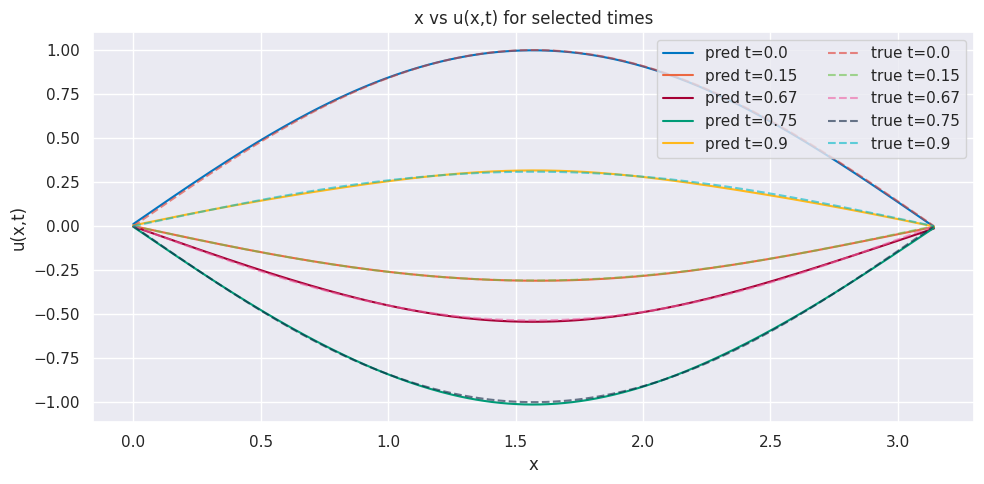

In [19]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot
plot_x_vs_u_at_times(pinn, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=300, L_val=L, with_exact=True)

In [20]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    u_n = pinn(torch.cat([xg_n, tg_n], dim=1))

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")

Grid relative error (u):     1.173181%


In the following cells, the velocity, acceleration and bending moment are obtained from the beam deflection and comparted to the analytical solutions.

In [21]:
def get_model_prediction(model, x_array, t_array, x_normalizer, t_normalizer):
    """
    Compute u(x,t) from model for all x and t.

    Returns:
        u_pred: torch.Tensor of shape [Nt, Nx]
    """
    Nx = len(x_array)
    Nt = len(t_array)

    Xg, Tg = np.meshgrid(x_array, t_array, indexing="xy")
    x_flat = Xg.ravel()
    t_flat = Tg.ravel()

    x_tensor = torch.tensor(x_flat, dtype=torch.float32)
    t_tensor = torch.tensor(t_flat, dtype=torch.float32, requires_grad=True)
    bias_tensor = torch.ones_like(x_tensor)

    # Normalize
    x_norm = x_normalizer.normalize(x_tensor)
    t_norm = t_normalizer.normalize(t_tensor)

    inputs = torch.stack([x_norm, t_norm, bias_tensor], dim=1)

    u_pred = model(inputs)[:, 1]  # u channel
    u_pred = u_pred.view(Nt, Nx)  # reshape [Nt, Nx]

    return u_pred, t_tensor, x_tensor

In [22]:
#Velocity (first derivative of deflection with respect to time)
def velocity_exact(x,t):
  return - 4*np.pi* torch.sin(x) * torch.sin(4 * np.pi * t)

def compute_velocity(u_pred, t_tensor_with_grad): #Compute du/dt
    velo = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]
    return velo

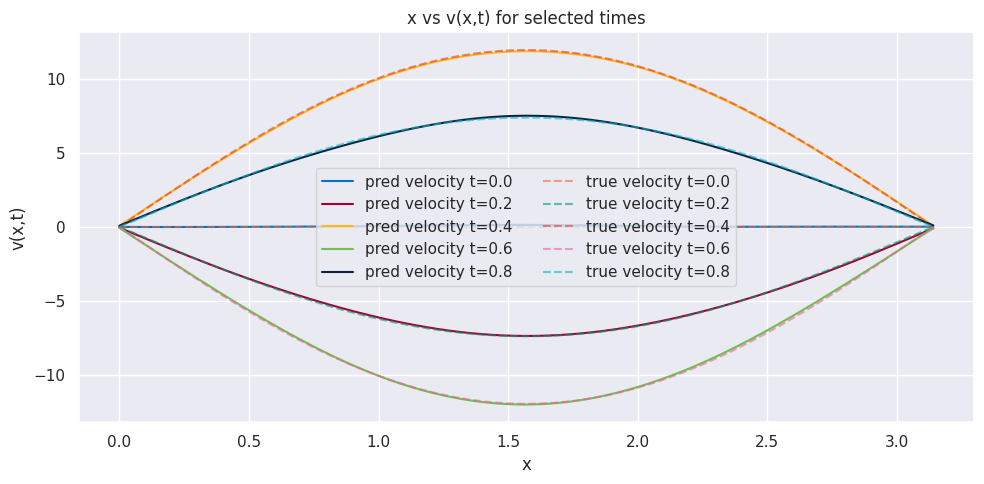

In [23]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_velocity(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted velocity
        predicted_velocity = compute_velocity(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted velocity
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_velocity.squeeze().cpu().detach().numpy(), label=f"pred velocity t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred velocity t={t_val}")

        # exact solution overlay
        if with_exact and 'velocity_exact' in globals():
            true_velocity = velocity_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_velocity.numpy(), '--', alpha=0.6, label=f"true velocity t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true velocity t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('v(x,t)')
    ax.set_title('x vs v(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the velocities
plot_x_vs_velocity(pinn, times=(0.0, 0.2, 0.4, 0.6, 0.8), Nx=300, L_val=L, with_exact=True)

In [24]:
#Acceleration (second derivative of deflection with respect to time)
def acceleration_exact(x,t):
  return - 14*np.pi**2 * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_acceleration(u_pred, t_tensor_with_grad): #Compute d^2u/dt^2
    # First derivative
    du_dt = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
    )[0]

    return d2u_dt2

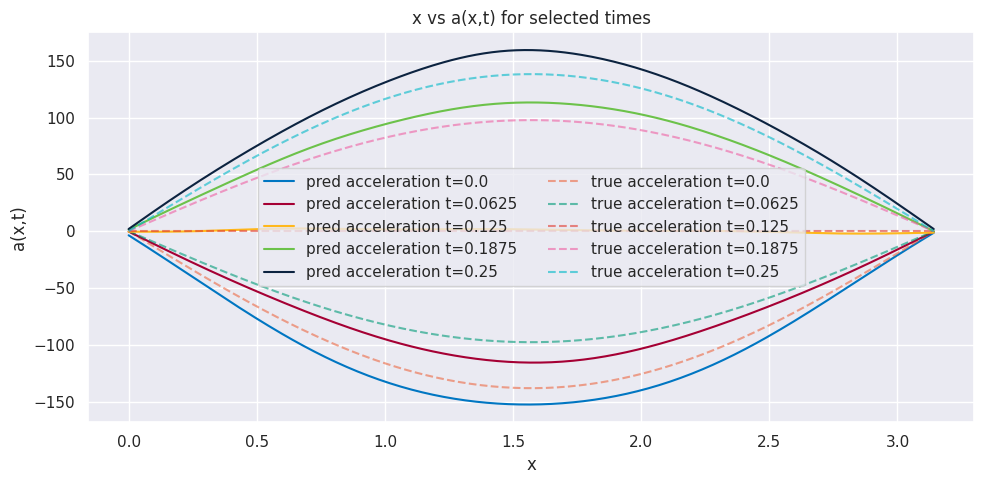

In [25]:
# Plot x vs a(x,t) for multiple time instants using the trained model

def plot_x_vs_acceleration(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted acceleration
        predicted_acceleration = compute_acceleration(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted acceleration
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_acceleration.squeeze().cpu().detach().numpy(), label=f"pred acceleration t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred acceleration t={t_val}")

        # exact solution overlay
        if with_exact and 'acceleration_exact' in globals():
            true_acceleration = acceleration_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_acceleration.numpy(), '--', alpha=0.6, label=f"true acceleration t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true acceleration t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('a(x,t)')
    ax.set_title('x vs a(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the accelerations
plot_x_vs_acceleration(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [26]:
#Bending moment (second derivative of deflection with respect to space multiplied with EI)
#M = -EI * d^2u/dx^2

def bending_moment_exact(x,t):
  return EI * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_bending_moment(u_pred, x_tensor_with_grad, EI):
    # First derivative wrt x
    du_dx = torch.autograd.grad(
        outputs=u_pred,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative wrt x
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
    )[0]

    M = -EI * d2u_dx2
    return M

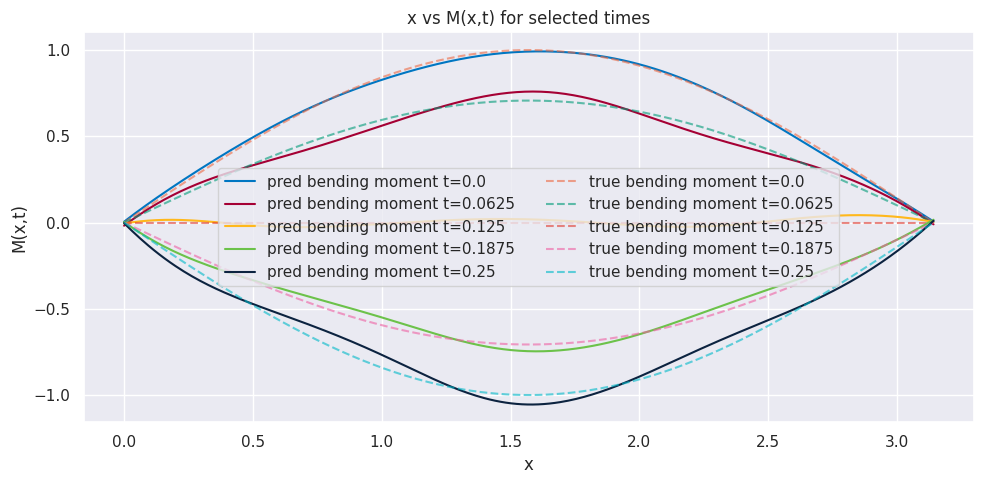

In [27]:
# Plot x vs M(x,t) for multiple time instants using the trained model

def plot_x_vs_bending_moment(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted bending moment
        predicted_bending_moment = compute_bending_moment(u_pred_output_denorm, x_tensor_for_grad, 1)

        # Plot predicted bending moment
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_bending_moment.squeeze().cpu().detach().numpy(), label=f"pred bending moment t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred bending moment t={t_val}")

        # exact solution overlay
        if with_exact and 'bending_moment_exact' in globals():
            true_bending_moment = bending_moment_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_bending_moment.numpy(), '--', alpha=0.6, label=f"true bending moment t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true bending moment t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('M(x,t)')
    ax.set_title('x vs M(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the bending moments
plot_x_vs_bending_moment(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [28]:
import numpy as np
import torch

Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

u_n = pinn(torch.cat([xg_n, tg_n], dim=1))
u_denorm_tensor = u_normalizer.denormalize(u_n)
u_pred_numpy = u_denorm_tensor.detach().cpu().numpy().reshape(Nx, Nt)
u_true_numpy = u_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

# Compute velocity, acceleration and bending moment, passing the denormalized u tensor and xg for bending moment
v_pred_tensor = compute_velocity(u_denorm_tensor, tg)
a_pred_tensor = compute_acceleration(u_denorm_tensor, tg)
M_pred_tensor = compute_bending_moment(u_denorm_tensor, xg, 1)

v_pred_numpy = v_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
a_pred_numpy = a_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
M_pred_numpy = M_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)

v_true_numpy = velocity_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
a_true_numpy = acceleration_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
M_true_numpy = bending_moment_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred_numpy - u_true_numpy) / np.linalg.norm(u_true_numpy) * 100
R_v = np.linalg.norm(v_pred_numpy - v_true_numpy) / np.linalg.norm(v_true_numpy) * 100
R_a = np.linalg.norm(a_pred_numpy - a_true_numpy) / np.linalg.norm(a_true_numpy) * 100
R_M = np.linalg.norm(M_pred_numpy - M_true_numpy) / np.linalg.norm(M_true_numpy) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (v):     {R_v:.6f}%")
print(f"Grid relative error (a):     {R_a:.6f}%")
print(f"Grid relative error (M):     {R_M:.6f}%")

Grid relative error (u):     1.173181%
Grid relative error (v):     1.135370%
Grid relative error (a):     14.541788%
Grid relative error (M):     8.644572%
